In [1]:
import sys, os
sys.path.append("C:\\Program Files\\Lumerical\\v231\\api\\python\\")
import lumapi
# sys.path.append(os.path.dirname(__file__))
import numpy as np
from tqdm import tqdm

um = 1e-6
N_doping = 1e17 #In [cm-3]
NN_doping = 1E18
NNN_doping = 1E19
P_doping = 1E17
PP_doping = 1E18
PPP_doping = 1E19

cathode_min_voltage = -0.5
cathode_max_voltage = 4
cathode_voltage_sweep_num_points = 6

In [2]:
dev1 = lumapi.DEVICE(filename="base_lateral_junction.ldev")
dev1.switchtolayout()


charge_object = dev1.select("CHARGE::boundary conditions::cathode");
dev1.set("range start",cathode_min_voltage)
dev1.set("range stop",cathode_max_voltage)
dev1.set("range num points",cathode_voltage_sweep_num_points)

charge_object = dev1.select("CHARGE::N")
dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

charge_object = dev1.select("CHARGE::NN")
dev1.set("concentration",NN_doping*1E6)

charge_object = dev1.select("CHARGE::NNN")
dev1.set("concentration",NNN_doping*1E6)

charge_object = dev1.select("CHARGE::P")
dev1.set("concentration",P_doping*1E6)

charge_object = dev1.select("CHARGE::PP")
dev1.set("concentration",PP_doping*1E6)

charge_object = dev1.select("CHARGE::PPP")
dev1.set("concentration",PPP_doping*1E6)

dev1.run("CHARGE")
dev1.close()

In [3]:
mode1 = lumapi.MODE(filename="base_junction.lms")
mode1.switchtolayout()
mode1.select("np density")
mode1.importdataset("charge.mat")

neff_sweep_storage = []

for i in tqdm(range(1,cathode_voltage_sweep_num_points+1),desc="mode_voltage_sweep"):
    mode1.switchtolayout()
    mode1.select("np density");
    mode1.set("V_cathode_index",i);
    mode1.run("FDE")
    mode1.findmodes()
    mode1.selectmode(1)
    neff = mode1.getdata("FDE::data::mode1","neff")
    neff_sweep_storage.append(np.squeeze(neff))

mode1.close()

In [8]:
neff_sweep_storage = np.array(neff_sweep_storage)
V_sweep = np.linspace(cathode_min_voltage,cathode_max_voltage,cathode_voltage_sweep_num_points)
delta_n = np.real(neff_sweep_storage)
delta_alpha = np.imag(neff_sweep_storage)

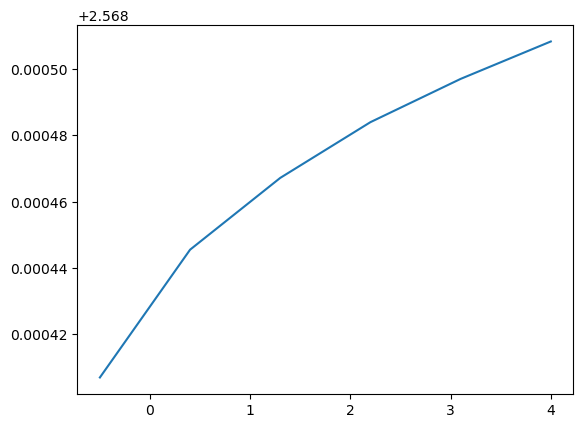

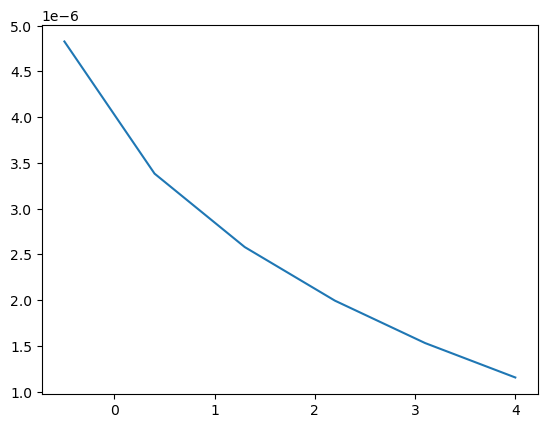

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(V_sweep,delta_n)
plt.show()
plt.figure()
plt.plot(V_sweep,delta_alpha)
plt.show()

In [2]:
#Cleanup
import os, shutil
try:
    os.remove("charge.mat")
except:
    pass
try:
    shutil.rmtree("base_junction_device_V_cathode_sweep")
except:
    pass

In [3]:
def run_full_sim(
    N_doping = 1e17, #In [cm-3]
    NN_doping = 1E18,
    NNN_doping = 1E19,
    P_doping = 1E17,
    PP_doping = 1E18,
    PPP_doping = 1E19,
    cathode_min_voltage = -0.5,
    cathode_max_voltage = 4,
    cathode_voltage_sweep_num_points = 11,
    ):
    dev1 = lumapi.DEVICE(filename="base_lateral_junction.ldev",hide=True)
    dev1.switchtolayout()
    charge_object = dev1.select("CHARGE::boundary conditions::cathode");
    dev1.set("range start",cathode_min_voltage)
    dev1.set("range stop",cathode_max_voltage)
    dev1.set("range num points",cathode_voltage_sweep_num_points)

    charge_object = dev1.select("CHARGE::N")
    dev1.set("concentration",N_doping*1E6) #The 1E6 is to compensate for going from cm-3 to m-3 in the API

    charge_object = dev1.select("CHARGE::NN")
    dev1.set("concentration",NN_doping*1E6)

    charge_object = dev1.select("CHARGE::NNN")
    dev1.set("concentration",NNN_doping*1E6)

    charge_object = dev1.select("CHARGE::P")
    dev1.set("concentration",P_doping*1E6)

    charge_object = dev1.select("CHARGE::PP")
    dev1.set("concentration",PP_doping*1E6)

    charge_object = dev1.select("CHARGE::PPP")
    dev1.set("concentration",PPP_doping*1E6)

    dev1.run("CHARGE")
    dev1.close()

    mode1 = lumapi.MODE(filename="base_junction.lms",hide=True)
    mode1.switchtolayout()
    mode1.select("np density")
    mode1.importdataset("charge.mat")

    neff_sweep_storage = []

    for i in range(1,cathode_voltage_sweep_num_points+1):
        mode1.switchtolayout()
        mode1.select("np density");
        mode1.set("V_cathode_index",i);
        mode1.run("FDE")
        mode1.findmodes()
        mode1.selectmode(1)
        neff = mode1.getdata("FDE::data::mode1","neff")
        neff_sweep_storage.append(np.squeeze(neff))

    mode1.close()

    neff_sweep_storage = np.array(neff_sweep_storage)
    V_sweep = np.linspace(cathode_min_voltage,cathode_max_voltage,cathode_voltage_sweep_num_points)
    delta_n = np.real(neff_sweep_storage)
    delta_alpha = np.imag(neff_sweep_storage)

    return V_sweep, neff_sweep_storage

In [9]:
storage_dict = {}
dopings = [1E16,3E16,1E17,3E17,1E18,3E18]
for i in tqdm(dopings,desc="Doping sweep"):
    voltage, neff = run_full_sim(N_doping=i,P_doping=i,cathode_min_voltage=-1.5,cathode_max_voltage=5.0,cathode_voltage_sweep_num_points=50)
    storage_dict[i] = (voltage,neff)

Doping sweep: 100%|██████████| 6/6 [2:30:48<00:00, 1508.07s/it]  


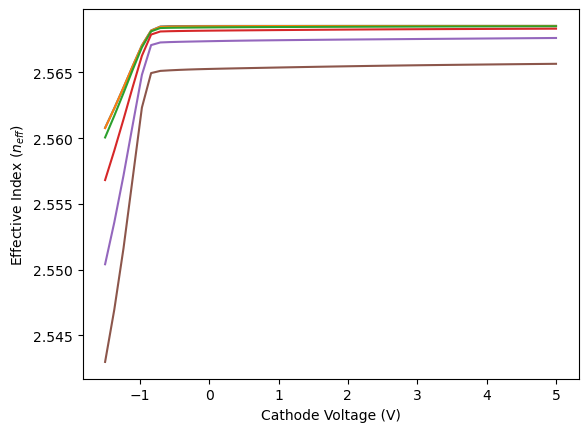

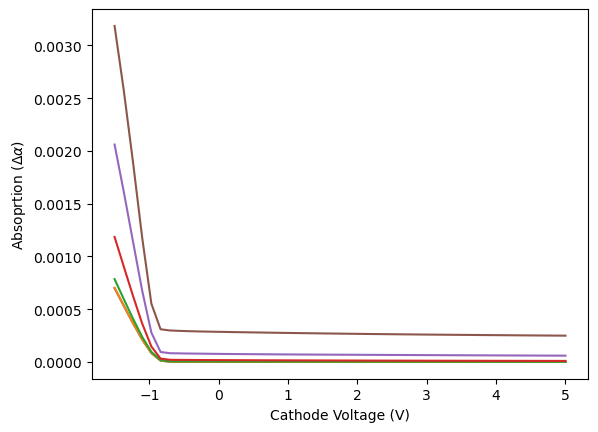

In [10]:
import matplotlib.pyplot as plt
plt.figure()
for i in dopings:
    plt.plot(storage_dict[i][0],np.real(storage_dict[i][1]))
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("Effective Index " + r"($n_{eff}$)")
plt.show()

plt.figure()
for i in dopings:
    plt.plot(storage_dict[i][0],np.imag(storage_dict[i][1]))
plt.xlabel("Cathode Voltage (V)")
plt.ylabel("Absoprtion " + r"($\Delta \alpha$)")
plt.show()

In [11]:
import pickle

with open("lateral_doping.pkl",'wb') as f:
    pickle.dump(storage_dict,f)